In [49]:
import pandas as pd
import numpy as np
import yfinance as yf
import requests
import time
import logging
import warnings

warnings.filterwarnings("ignore")

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)

logger = logging.getLogger(__name__)

symbol = 'BTCUSDT'
qty = 0.002

Get Past Data

In [50]:
def get_kline_data(pair, interval = "1h", limit = 1):
    try:
        # User inputs
        # Prepare the request body (JSON)
        params = {
            'pair': pair,
            'interval': interval,
            'limit': limit
        }

        # Headers for the POST request (no API key or signature required)
        headers = {
            'Content-Type': 'application/json'
        }

        
        kline_url = "https://api.pi42.com/v1/market/klines"

        for attempt in range(3):
            try:
                response = requests.post(kline_url, json=params, headers=headers)
                response.raise_for_status() # Raises an error for 4xx/5xx responses
                response_data = response.json()
                break  

            except requests.exceptions.RequestException:
                print(f"Retrying... ({attempt + 1})")
                time.sleep(10)  
        
        return response_data

    except ValueError:
        print("Please enter valid inputs for pair, interval.")
    except requests.exceptions.HTTPError as err:
        print(f"Error: {err.response.text if err.response else err}")
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")



def make_init_data(contract_pair, time = "1h", limit = 100):
    
    try:
        logger.info(f"Fetching kline data for contract pair: {contract_pair}")
        info = get_kline_data(contract_pair, interval=time, limit=limit)
        
        data = []

        for i in info:
            high = float(i['high'])
            low = float(i['low'])
            close = float(i['close'])
            
            timestamp = pd.to_datetime(int(i['startTime']), unit='ms')
            
            data.append({'Timestamp': timestamp, 'High': high, 'Low': low, 'Close': close})
        
        # Create the DataFrame
        df = pd.DataFrame(data)
        df.set_index('Timestamp')
        df.index = pd.to_datetime(df.index)
        
        logger.info("DataFrame created successfully.")
        return df
    
    except Exception as e:
        logger.error(f"Error while making initial data: {e}")
        raise

In [60]:
df = make_init_data('BTCUSDT', time = "1d", limit = 1000)

2025-01-19 22:06:16,927 - INFO - Fetching kline data for contract pair: BTCUSDT
2025-01-19 22:06:17,298 - INFO - DataFrame created successfully.


In [61]:
len(df)

293

In [62]:
def get_supertrend(high, low, close, lookback, multiplier):
    
    # ATR
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(lookback).mean()
    
    # H/L AVG AND BASIC UPPER & LOWER BAND
    
    hl_avg = (high + low) / 2
    upper_band = (hl_avg + multiplier * atr).dropna()
    lower_band = (hl_avg - multiplier * atr).dropna()
    
    # FINAL UPPER BAND
    final_bands = pd.DataFrame(columns = ['upper', 'lower'])
    final_bands.iloc[:,0] = [x for x in upper_band - upper_band]
    final_bands.iloc[:,1] = final_bands.iloc[:,0]
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i,0] = 0
        else:
            if (upper_band[i] < final_bands.iloc[i-1,0]) | (close[i-1] > final_bands.iloc[i-1,0]):
                final_bands.iloc[i,0] = upper_band[i]
            else:
                final_bands.iloc[i,0] = final_bands.iloc[i-1,0]
    
    # FINAL LOWER BAND
    
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i, 1] = 0
        else:
            if (lower_band[i] > final_bands.iloc[i-1,1]) | (close[i-1] < final_bands.iloc[i-1,1]):
                final_bands.iloc[i,1] = lower_band[i]
            else:
                final_bands.iloc[i,1] = final_bands.iloc[i-1,1]
    
    # SUPERTREND
    
    supertrend = pd.DataFrame(columns = [f'supertrend_{lookback}'])
    supertrend.iloc[:,0] = [x for x in final_bands['upper'] - final_bands['upper']]
    
    for i in range(len(supertrend)):
        if i == 0:
            supertrend.iloc[i, 0] = 0
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] < final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] > final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] > final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] < final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
    
    supertrend = supertrend.set_index(upper_band.index)
    supertrend = supertrend.dropna()[1:]
    
    # ST UPTREND/DOWNTREND
    
    upt = []
    dt = []
    close = close.iloc[len(close) - len(supertrend):]

    for i in range(len(supertrend)):
        if close[i] > supertrend.iloc[i, 0]:
            upt.append(supertrend.iloc[i, 0])
            dt.append(np.nan)
        elif close[i] < supertrend.iloc[i, 0]:
            upt.append(np.nan)
            dt.append(supertrend.iloc[i, 0])
        else:
            upt.append(np.nan)
            dt.append(np.nan)
            
    st, upt, dt = pd.Series(supertrend.iloc[:, 0]), pd.Series(upt), pd.Series(dt)
    upt.index, dt.index = supertrend.index, supertrend.index
    
    return st, upt, dt, atr

In [63]:
df['st'], df['st_upt'], df['st_dt'], df['atr'] = get_supertrend(df['High'], df['Low'], df['Close'], 10, 3)

In [64]:
len(df)

293

BUY SIGNAL

In [65]:
length = len(df['st_upt'])
close = list(df['Close'])
st_upt = list(df['st_upt'])
status = 0
capital_real = 40
lev = 25

capital = capital_real * 25

equity_curve = [capital_real]

for i in range(1, length):
    #print(i)
    curr = st_upt[i]
    prev = st_upt[i - 1]

    if pd.isna(prev) and curr > 0 and status == 0:
        logger.info("BUY SIGNAL detected.")
        entry_price = close[i]
        logger.info(f"Buy Price: {entry_price}")
        status = 1
    
    if pd.isna(curr) and prev > 0 and status == 1:
        logger.info("SELL SIGNAL detected.")
        exit_price = close[i]
        logger.info(f"Sell Price: {exit_price}")
        status = 0
        
        qty = capital / entry_price
        logger.info(f"Qty: {qty}")
        diff = capital_real + (exit_price - entry_price) * qty
        logger.info(f"Diff: {diff}")

        equity_curve.append(diff)
        

2025-01-19 22:06:22,769 - INFO - BUY SIGNAL detected.
2025-01-19 22:06:22,771 - INFO - Buy Price: 71466.5
2025-01-19 22:06:22,773 - INFO - SELL SIGNAL detected.
2025-01-19 22:06:22,777 - INFO - Sell Price: 64124.0
2025-01-19 22:06:22,779 - INFO - Qty: 0.013992569945359015
2025-01-19 22:06:22,781 - INFO - Diff: -62.74044482379857
2025-01-19 22:06:22,783 - INFO - BUY SIGNAL detected.
2025-01-19 22:06:22,785 - INFO - Buy Price: 64680.6
2025-01-19 22:06:22,786 - INFO - SELL SIGNAL detected.
2025-01-19 22:06:22,788 - INFO - Sell Price: 60684.6
2025-01-19 22:06:22,790 - INFO - Qty: 0.015460586327275877
2025-01-19 22:06:22,792 - INFO - Diff: -21.780502963794405
2025-01-19 22:06:22,794 - INFO - BUY SIGNAL detected.
2025-01-19 22:06:22,795 - INFO - Buy Price: 64020.0
2025-01-19 22:06:22,797 - INFO - SELL SIGNAL detected.
2025-01-19 22:06:22,798 - INFO - Sell Price: 56145.6
2025-01-19 22:06:22,800 - INFO - Qty: 0.015620118712902219
2025-01-19 22:06:22,801 - INFO - Diff: -82.99906279287725
2025-0

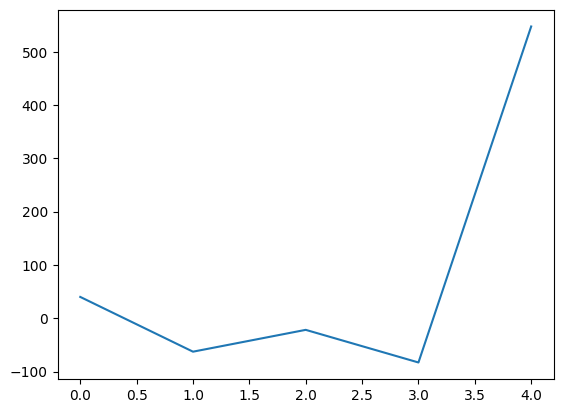

In [66]:
import matplotlib.pyplot as plt
plt.plot(equity_curve)

In [67]:
length = len(df['st_upt'])
close = list(df['Close'])
st_upt = list(df['st_upt'])
status = 0
capital_real = 1000
lev = 25

capital = capital_real * 25

equity_curve = [capital_real]

for i in range(1, length):
    #print(i)
    curr = st_upt[i]
    prev = st_upt[i - 1]

    if pd.isna(prev) and curr > 0 and status == 1:
        logger.info("BUY SIGNAL detected.")
        entry_price = close[i]
        logger.info(f"Buy Price: {entry_price}")
        status = 0

        qty = capital / exit_price
        logger.info(f"Qty: {qty}")
        diff = capital_real + (exit_price - entry_price) * qty
        logger.info(f"Diff: {diff}")

        equity_curve.append(diff)
    
    if pd.isna(curr) and prev > 0 and status == 0:
        logger.info("SELL SIGNAL detected.")
        exit_price = close[i]
        logger.info(f"Sell Price: {exit_price}")
        status = 1

2025-01-19 22:06:23,328 - INFO - SELL SIGNAL detected.
2025-01-19 22:06:23,331 - INFO - Sell Price: 64124.0
2025-01-19 22:06:23,333 - INFO - BUY SIGNAL detected.
2025-01-19 22:06:23,335 - INFO - Buy Price: 64680.6
2025-01-19 22:06:23,337 - INFO - Qty: 0.3898696275965317
2025-01-19 22:06:23,339 - INFO - Diff: 782.998565279771
2025-01-19 22:06:23,342 - INFO - SELL SIGNAL detected.
2025-01-19 22:06:23,344 - INFO - Sell Price: 60684.6
2025-01-19 22:06:23,346 - INFO - BUY SIGNAL detected.
2025-01-19 22:06:23,348 - INFO - Buy Price: 64020.0
2025-01-19 22:06:23,349 - INFO - Qty: 0.4119661330881311
2025-01-19 22:06:23,351 - INFO - Diff: -374.0718403021531
2025-01-19 22:06:23,353 - INFO - SELL SIGNAL detected.
2025-01-19 22:06:23,355 - INFO - Sell Price: 56145.6
2025-01-19 22:06:23,357 - INFO - BUY SIGNAL detected.
2025-01-19 22:06:23,358 - INFO - Buy Price: 62926.9
2025-01-19 22:06:23,360 - INFO - Qty: 0.4452708671739192
2025-01-19 22:06:23,367 - INFO - Diff: -2019.5153315664998
2025-01-19 22:

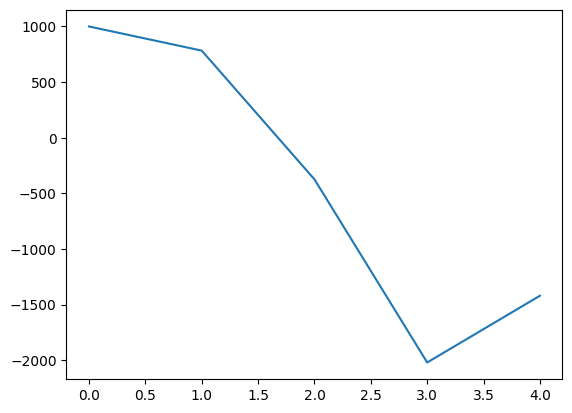

In [68]:
plt.plot(equity_curve)